# CNN for Proteins
Now that I am done with the diversion, its time to do what I came here to do. The first thing that I want to do is to make an Inceptionv2, hand coded in Keras in order to see if I have learned anything.



**Some Notes about the COMP**
- There are 4 filters 
    - Green --> Protein of Interest
    - Red --> mictrotubules
    - Blue --> Nucleus 
    - Yellow --> endoplasmic reticulum

In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from PIL import Image
#from tensorflow import keras

import tensorflow as tf
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate as con
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

import os

In [2]:
label_map = {
    0:"Nucleoplasm",
    1:"Nuclear membrane",  
    2:"Nucleoli",   
    3:"Nucleoli fibrillar center",
    4:"Nuclear speckles",
    5:"Nuclear bodies",
    6:"Endoplasmic reticulum",
    7:"Golgi apparatus",  
    8:"Peroxisomes",
    9:"Endosomes",   
    10:"Lysosomes", 
    11:"Intermediate filaments",
    12:"Actin filaments",
    13:"Focal adhesion sites",
    14:"Microtubules",
    15:"Microtubule ends",
    16:"Cytokinetic bridge",
    17:"Mitotic spindle",  
    18:"Microtubule organizing center",  
    19:"Centrosome",
    20:"Lipid droplets",
    21:"Plasma membrane",
    22:"Cell junctions",
    23:"Mitochondria",
    24:"Aggresome",
    25:"Cytosol",
    26:"Cytoplasmic bodies",
    27:"Rods & rings"

}

In [3]:
MAIN_DIR = os.path.join(os.getcwd(),"Pics/Proteins")
TRAIN_DIR = MAIN_DIR + "/train"
TEST_DIR = MAIN_DIR + "/test"
LABELS = MAIN_DIR+ "/train.csv"

In [4]:
MAIN_DIR

'/home/paperspace/fastai/focus/Pics/Proteins'

In [5]:
n_classes = 28
batch_sizes = 12

# Looking at the Data

I am not too familiar with biology, so I need to look at the data to see what I am Dealing with

In [6]:
#read all of the data that is in the csv file Kaggle gave me
data = pd.read_csv(LABELS)

In [7]:
data.shape

(31072, 2)

In [8]:
data.head(25)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


**The Images**


I really wanted to see how all four of the images looked like. When I opned themselves, they were just black and white, so I knew that I had to run it in a notebook. 

In [9]:
# Credits https://www.kaggle.com/wordroid/keras-inceptionresnetv2-resize139x139 

# Return a an array of all four of the images 
def get_arr0(Id, test=False):
    # Finds all of the images of the ID given
    def fn(Id, color, test=False):
        if test:
            tgt = 'test'
        else:
            tgt = 'train'
            # Open the image and formats it . 
        with open(os.path.join(MAIN_DIR, tgt, Id+'_{}.png'.format(color)), 'rb') as fp:
            img = Image.open(fp)
            arr = (np.asarray(img) / 255.)
        return arr
    res = []
    for icolor in ['green', 'blue', 'red', 'yellow']:
        arr0 = fn(Id, icolor, test)
        res.append(arr0)
    arr = np.stack(res, axis=-1)
    return arr
# This function actually displays the array
def show_arr(arr, nrows = 1, ncols = 4, figsize=(15, 5)):
    #Makes supblots through matplotlib
    fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ii in range(ncols):
        iplt = subs[ii]
        #Takes the last part of the name
        img_array = arr[:,:,ii]
        if ii == 0:
            cp = 'Greens'
        elif ii == 1:
            cp = 'Blues'
        elif ii == 2:
            cp = 'Reds'
        else:
            cp = 'Oranges'
        #Displays the image with the correct colouring
        iplt.imshow(img_array, cmap=cp)

(512, 512, 4)


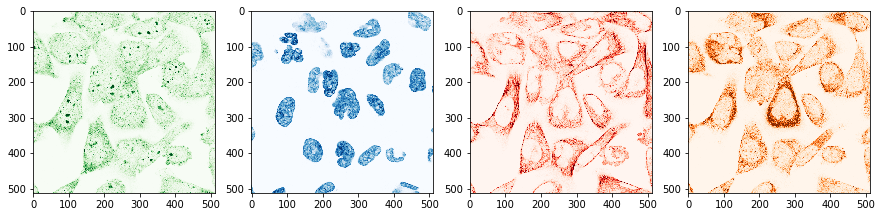

In [10]:
sample = get_arr0("0020af02-bbba-11e8-b2ba-ac1f6b6435d0")
print(sample.shape)
show_arr(sample)

(512, 512, 4)


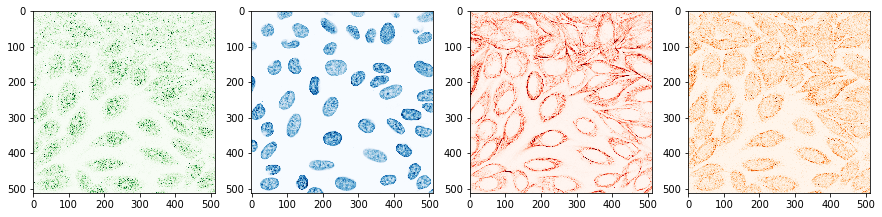

In [11]:
sample1 = get_arr0("0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0")
print(sample.shape)
show_arr(sample1)

(512, 512, 4)


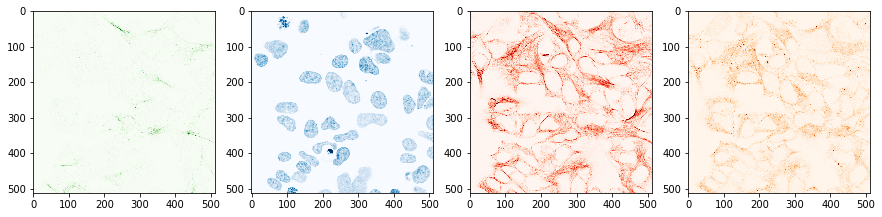

In [12]:
sample3 = get_arr0("0047c984-bba6-11e8-b2ba-ac1f6b6435d0")
print(sample3.shape)
show_arr(sample3)

# Preprocessing the images
Now that I have familiarized myself with how the dataset looks like, I am ready to go through the train.csv file and start to load images into the model. 

I first start off by making a list called train_dataset_info which goes through each of the two roads in the file and adds a small dictionary to each index. This process allows me to see the path to the image and the labels associated with that image simultaneously.  

In [13]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(TRAIN_DIR, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)


**Some Problems**


I orignally was trying to brute force the generator for the images, as I did not want to feed all of the images at once. After too many unsuccessful tries, I decided to bite the bullet and see how other Kagglers dealt with this. To my surprise everyone was using a variation of this class and its methods to create their train dataset. 

This class will generate the batches and even augment some of the images in order to diversify the dataset. I don't know who originally created this, since everyone was using this, but the first one I saw was by  https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379 . 

In [14]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379

class datagenerator:
    
    def create_train(dataset_info, batch_size, shape, augment=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = datagenerator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augment:
                        image = datagenerator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

## Training and Valid splits

Split the total number of indexes into train and validation. This allows us to feed in many images for the weights and biases to be found and also check up on how these values are working throughout the process. Once we split up the indexes, we put them through the generator method

In [15]:
train_indexes, valid_indexes = train_test_split(np.arange(train_dataset_info.shape[0]), test_size=0.3, random_state=8)

In [16]:
train_gen = datagenerator.create_train(train_dataset_info[train_indexes],64,
                                       (224,224,3), augment = True )
valid_gen= datagenerator.create_train(train_dataset_info[valid_indexes], 32, 
                                      (224,224,3),augment =False)

In [17]:
pics = datagenerator.create_train(train_dataset_info, 5, (512,512,3), augment = False)

**Looking at more images**


Before, we saw the four images seperately, so I want to see how they look stacked together

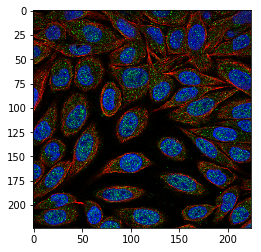

In [18]:
pic = datagenerator.load_image(TRAIN_DIR+"/0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0",
                               (224,224,3))
plt.imshow(pic)

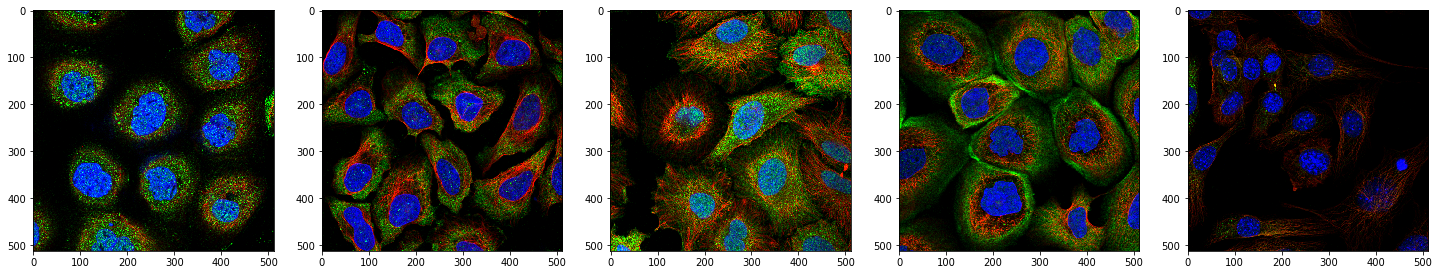

In [19]:
images, labels = next(pics)

fig,ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])

In [20]:
K.image_data_format()

'channels_last'

# The Model

This is the CNN that I used for the Proteins dataset. The model shown is the same CNN base that is used by the CNNLSTM


In [25]:
input_shape=(224,224,3)


inputs = Input(name='the_input', shape=input_shape, dtype='float32')  

# Convolution layer (VGG)
# First Block
inner = Conv2D(64, (3, 3), padding='same', name='conv1', 
               kernel_initializer='he_normal')(inputs) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  
inner = Dropout(0.25)(inner)

# Second Block
inner = Conv2D(128, (3, 3), padding='same', name='conv3', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  
inner = Dropout(0.25)(inner)

#Third Block
inner = Conv2D(256, (3, 3), padding='same', name='conv5', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv6', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max3')(inner)
inner = Dropout(0.25)(inner)


#Fourth Block
inner = Conv2D(512, (3, 3), padding='same', name='conv8', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv9')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max4')(inner)
inner = Dropout(0.25)(inner)


#Fifth Block
inner = Conv2D(512, (3, 3), padding='same', 
               kernel_initializer='he_normal', name='con11')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', 
               kernel_initializer='he_normal', name='con12')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', 
               kernel_initializer='he_normal', name='con13')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max5')(inner) 
inner = Dropout(0.25)(inner)


#Refinement
inner = Dense(64, kernel_initializer ='he_normal')(inner)
inner = Dropout(0.25)(inner)
inner = Flatten()(inner)
inner = Dense(4096, kernel_initializer='he_normal', name = 'fc1')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Dropout(0.5)(inner)
inner = Dense(4096, kernel_initializer='he_normal', name = 'fc2')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Dropout(0.1)(inner)
inner = Dense(n_classes, kernel_initializer = 'he_normal',name='dense1')(inner)
inner = BatchNormalization()(inner)
finalPred = Activation('sigmoid')(inner)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
model = Model(inputs=inputs, outputs= finalPred)

In [27]:
# Define a function to calculate f1 at each interval
# Credit to https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [28]:
model.compile(optimizer=Adam( lr=0.001, decay=1e-6), loss='binary_crossentropy',
              metrics=['accuracy',f1])

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv3 (Conv2D)               (None, 112, 112, 128)     73856     
__________

In [28]:
len(train_indexes)  // 64

339

In [29]:
len(valid_indexes) // 16

582

In [30]:
model.reset_states()

# Training the model 
This part of the code is how we train the model. 

In [31]:
filepath = "CNN-Proteins-{epoch:02d}.hdf5"

earlyStop = EarlyStopping(monitor ='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max')
callback =  ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

hist = model.fit_generator(
    generator = train_gen, 
    steps_per_epoch=len(train_indexes)//64, 
    epochs=10, 
    verbose=1,
    validation_data=valid_gen,
    validation_steps = 8 ,
    callbacks = [ callback, checkpoint, earlyStop]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8/8 [==============================] - 22s 3s/step - loss: 0.7079 - acc: 0.8205 - f1: 0.0852

Epoch 00001: val_f1 improved from -inf to 0.08516, saving model to VGG19-MULTI-PROTEINZ-01.hdf5
339/339 [==============================] - 9357s 28s/step - loss: 0.6702 - acc: 0.7126 - f1: 0.0905 - val_loss: 0.7079 - val_acc: 0.8205 - val_f1: 0.0852
Epoch 2/10
8/8 [==============================] - 22s 3s/step - loss: 0.4864 - acc: 0.9159 - f1: 0.0849

Epoch 00002: val_f1 did not improve from 0.08516
339/339 [==============================] - 9062s 27s/step - loss: 0.5300 - acc: 0.9211 - f1: 0.0919 - val_loss: 0.4864 - val_acc: 0.9159 - val_f1: 0.0849
Epoch 3/10
8/8 [==============================] - 25s 3s/step - loss: 0.4023 - acc: 0.9372 - f1: 0.0856

Epoch 00003: val_f1 improved from 0.08516 to 0.08564, saving model to VGG19-MULTI-PROTEINZ-03.hdf5
339/339 [==============================] - 9091s 27s/step - loss: 0.4282 - acc: 0.938

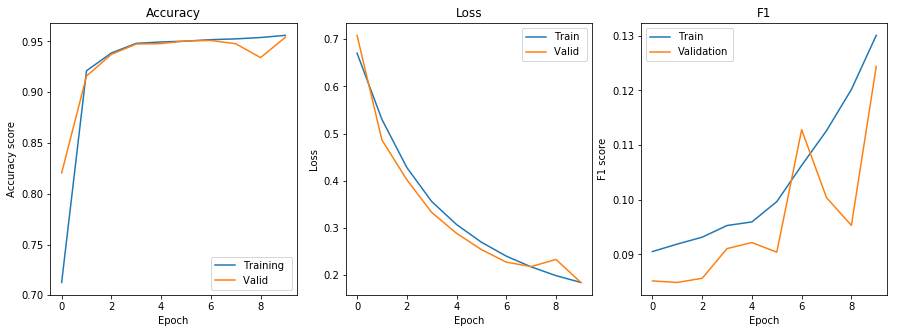

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Accuracy')
#ax[0].xlabel('Epoch')
#ax[0].ylabel('Accuracy')
ax[0].plot(hist.history['acc'], label = "Training ")
ax[0].plot(hist.history['val_acc'], label = "Valid ")
ax[0].set(xlabel="Epoch", ylabel="Accuracy score")

ax[1].set_title('Loss')
#ax[1].ylabel('Loss')
#ax[1].xlabel('Epoch')
ax[1].plot(hist.history['loss'], label= 'Train ')
ax[1].plot(hist.history['val_loss'], label = 'Valid ')
ax[1].set(xlabel="Epoch", ylabel="Loss")

ax[2].set_title('F1')
#ax[2].ylabel('F1 Score')
#ax[2].xlabel('Epoch')
ax[2].set(xlabel="Epoch", ylabel="F1 score")
ax[2].plot(hist.history['f1'], label = "Train")
ax[2].plot(hist.history['val_f1'], label = "Validation")
ax[2].legend(['train', 'validation'])

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('CNN_PROTEINS_RESULTS.png')


In [37]:
valid_indexes

array([ 2778, 29365,  3519, ..., 12782,  9214, 13481])

# Testing the model 


In [41]:
model.load_weights('CNN-Proteins-10.hdf5')
preds = model.predict_generator(valid_gen, steps = len(valid_indexes)//32, verbose =1)

291/291 [==============================] - 749s 3s/step


In [42]:
predictions=[]
filenames = []
for i in range(len(preds)):
    filenames.append(train_dataset_info[i]['path'])
columns=list(label_map.keys())
for i in range(len(preds)):
    l=[]
    for j in range(len(preds[i])):
        if preds[i][j] >= 0.5:
            l.append(preds[i][j])
        else:
            l.append(0)
    predictions.append(l)
            
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["path"]=filenames
ordered_cols=["path"]+columns
results=results[ordered_cols]#To get the same column order
print(results)
results.to_csv("CNN_PRTOEINS_results.csv",index=False)

                                                   path         0  1  \
0     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
1     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
2     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
3     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
4     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.881025  0   
5     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.592991  0   
6     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.893525  0   
7     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
8     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.778810  0   
9     /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.000000  0   
10    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.893391  0   
11    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.756007  0   
12    /home/paperspace/fastai/focus/Pics/Proteins/tr...  0.84652

In [43]:
count = 0
for i in range(len(preds)):
    for j in range(len(preds[i])):
        if preds[i][j] >= 0.5:
            count += 1

In [44]:
count

9095